In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import json
import seaborn
seaborn.set()

In [2]:
def jsonify(x): # converts json strings to dictionaries
    return json.loads(x)

In [3]:
def json_to_list(x, value): # https://stackoverflow.com/a/7271523
    return [d[value] for d in x]

In [4]:
data_movie = pd.read_csv(
    'tmdb/tmdb_5000_movies.csv.gz',
    compression='gzip',
    parse_dates=['release_date'],
    converters={'genres': lambda x: jsonify(x),
                'keywords': lambda x: jsonify(x),
                'production_companies': lambda x: jsonify(x),
               }
)

# filter
data_movie = data_movie[data_movie['original_language'] == 'en']
data_movie = data_movie[data_movie['vote_count'] >= 50]
drop = ['homepage', 'original_language', 'overview', 'popularity', 'production_countries', 'status', 'spoken_languages', 'tagline']
data_movie = data_movie.drop(drop, axis=1)

# add relevant attributes
data_movie['profit'] = data_movie['revenue'] - data_movie['budget']
data_movie['month'] = data_movie['release_date'].dt.month # thank you exercise 5

# convert json string to dictionary
data_movie['genres'] = data_movie['genres'].apply(lambda x: json_to_list(x, 'id'))
data_movie['keywords'] = data_movie['keywords'].apply(lambda x: json_to_list(x, 'id'))
data_movie['production_companies'] = data_movie['production_companies'].apply(lambda x: json_to_list(x, 'id'))

# data_movie

In [5]:
data_credits = pd.read_csv(
    'tmdb/tmdb_5000_credits.csv.gz',
    compression='gzip',
    converters={'cast': lambda x: jsonify(x),
                'crew': lambda x: jsonify(x),
               })

# filter
drop = ['title', 'crew']
data_credits = data_credits.drop(drop, axis=1)

# convert
data_credits['cast'] = data_credits['cast'].apply(lambda x: json_to_list(x, 'id'))

# data_credits

In [6]:
# combine cast members and 
data = pd.merge(data_movie, data_credits, left_on='id', right_on='movie_id')

In [7]:
# correlation between profit and rating
reg = stats.linregress(data.profit, data.vote_average)
m, b = reg.slope, reg.intercept
reg.pvalue

4.884804488965055e-47

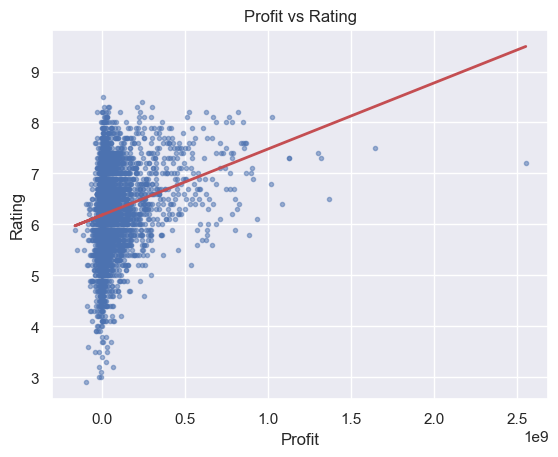

In [8]:
plt.plot(data.profit, data.vote_average, 'b.', alpha=0.5)
plt.plot(data.profit, m*data.profit+b, 'r-', linewidth=2)
plt.xlabel('Profit')
plt.ylabel('Rating')
plt.title('Profit vs Rating')
plt.show()

In [9]:
# filter
drop = ['id', 'original_title', 'release_date', 'title', 'movie_id', 'cast']
data_explode = data.drop(drop, axis=1)
data_explode = data_explode.join(data_explode['genres'].explode().rename('target'))
data_explode['genres'] = [[a for a in x if a != y] 
                               for x,y in zip(data_explode['genres'], data_explode['target'])]
data_explode = data_explode[data_explode['genres'].str.len() != 0].reset_index()
data_explode = data_explode.drop('target', axis=1)
# data_explode

In [10]:
data_explode = data_explode.explode('keywords')
data_explode = data_explode.explode('production_companies')

In [11]:
X_columns = ['budget', 'genres', 'keywords', 'production_companies', 'runtime', 'month']
X = data_explode[X_columns]
# replace NaN with 0
X = X.replace(np.nan,0)
# convert list to string
X['genres'] = X['genres'].map(tuple)

In [12]:
# X = X.astype({'genres': 'category', 'keywords': 'category', 'production_companies': 'category', 'month':'category'})
# X['keywords']

In [13]:
# encode each column
from sklearn.preprocessing import LabelEncoder

def encode(column):
    encoder = LabelEncoder()
    encoder.fit(column)
    encoded = encoder.transform(column)
    return encoded

# columns = ['genres', 'keywords', 'production_companies']
columns = ['genres']
for column in columns:
    X_column = X[column]
    encoded = encode(X_column)
    X[column] = encoded

In [14]:
y = data_explode['profit']

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [16]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=20)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.7704358783287253
0.748368604129557


In [17]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.9999997642062132
0.9994164925104119


In [18]:
# this takes a while to run
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.9999611265175717
0.9998300174201191


In [19]:
y = pd.DataFrame(data_explode['vote_average'])
# categorize data

In [20]:
# https://stackoverflow.com/a/64671466
# y['vote_average'] = y.assign(vote_average=pd.cut(y['vote_average'],
#                                                  bins=[0, 5, 7, 10],
#                                                  labels =['Bad', 'Average', 'Good']))
y['vote_average'] = y.assign(vote_average=pd.cut(y['vote_average'],
                                                 bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                                                 labels =['Appalling', 'Horrible', 'Very Bad', 'Bad', 'Average', 'Fine', 'Good', 'Very Good', 'Great', 'Masterpiece']))
y = y['vote_average']

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20)
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

0.746605896537836
0.7120658275086796


In [23]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

from sklearn import tree
tree.export_graphviz(model, out_file='tree.dot', max_depth=5)

1.0
0.9988987963232033


In [24]:
# this takes a while to run
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_valid, y_valid))

1.0
0.9995717541256902
